In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Extract cell activity and trial variables from simulation results

In [56]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
task_input = np.zeros((2, n_trials))
v1v2_values = np.zeros((2, n_trials))
wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rMD = np.array(data["network_rates"]["r_MD"])
        rMD_trials[idx,:,:] = rMD
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        v1v2_values[:,idx] = trial_task_input[2:]
        
        wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])


# Compute cue responsiveness across all 4 strategy/cue combinations

NOTE: We remove association level 0.5 form the analysis. 
Match strategy considers all trials in association level blocks of 0.7 and 0.9.
Non-match strategy considers all trials in association level blocks of 0.1 and 0.3.

## Util Functions

In [46]:
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable
    
def linear_regression(x, y):    
    X = np.transpose([np.ones(len(x)), x])
    model_fit = sm.OLS(y, X).fit()
    return (model_fit.rsquared, model_fit.params[1], model_fit.params[0])

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

## Step 1: Look for a linear relationship between trials and V1 value across match/non-match vs cue=up/cue=down trials.

In [55]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032421_v1-permutations'

CUE_TIME = 100
TRIAL_SAMPLE_SIZE = 150

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

V_r2 = np.zeros((N_PFC_NEURONS, 4))
V_coeff = np.zeros((N_PFC_NEURONS, 4))

for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)

    match_trials = np.concatenate((alevel_90_trials, alevel_70_trials))
    nonmatch_trials = np.concatenate((alevel_10_trials, alevel_30_trials))
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
        
    cue = task_input[0, trials]    
    trials_match_cue1 = match_trials[np.where(cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_match_cue2 = match_trials[np.where(1-cue[0:2*TRIAL_SAMPLE_SIZE])]
    trials_nonmatch_cue1 = nonmatch_trials[np.where(cue[2*TRIAL_SAMPLE_SIZE:])]
    trials_nonmatch_cue2 = nonmatch_trials[np.where(1-cue[2*TRIAL_SAMPLE_SIZE:])]
        
    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
    
    fr_match_cue1 = np.mean(rPFC_trials[trials_match_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_match_cue2 = np.mean(rPFC_trials[trials_match_cue2, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue1 = np.mean(rPFC_trials[trials_nonmatch_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue2 = np.mean(rPFC_trials[trials_nonmatch_cue2, cuetime_s:cuetime_t, neuron_idx],1)

    (r2_match_cue1, coeff_match_cue1, const_match_cue1) = linear_regression(fr_match_cue1, v1_match_cue1)
    (r2_match_cue2, coeff_match_cue2, const_match_cue2) = linear_regression(fr_match_cue2, v1_match_cue2)
    (r2_nonmatch_cue1, coeff_nonmatch_cue1, const_nonmatch_cue1) = linear_regression(fr_nonmatch_cue1, v1_nonmatch_cue1)
    (r2_nonmatch_cue2, coeff_nonmatch_cue2, const_nonmatch_cue2) = linear_regression(fr_nonmatch_cue2, v1_nonmatch_cue2)
    V_r2[neuron_idx,:] = [r2_match_cue1, r2_match_cue2, r2_nonmatch_cue1, r2_nonmatch_cue2]
    V_coeff[neuron_idx,:] = [coeff_match_cue1, coeff_match_cue2, coeff_nonmatch_cue1, coeff_nonmatch_cue2]

    
    plt.figure(figsize=(20,10))

    w = 0.3
    x = np.arange(4)
    ax1 = plt.subplot(2,4,1)
    plt.xticks(x, ["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"])
    ax1.bar(x-w/2, V_r2[neuron_idx,:], width=w, color="red")
    plt.ylabel("R-squared")
    plt.ylim([0,1])
    ax2 = ax1.twinx()
    ax2.bar(x+w/2, abs(V_coeff[neuron_idx,:]), width=w)
    plt.ylabel("abs(Coeffs)")
    plt.title(f"Neuron idx = {neuron_idx}")

    ax2 = plt.subplot(2,4,5)
    ax2.scatter(fr_match_cue1, v1_match_cue1, marker=".")
    ax2.plot(x, V_coeff[neuron_idx,0]*x + const_match_cue1)
    ax2.set_xlim((0,1))
    ax2.set_ylim((0,1))
    ax2.set_title("match/cue1")
    ax2.set_xlabel("neuron firing rate")
    ax2.set_ylabel("V1 value")
    
    ax3 = plt.subplot(2,4,6)
    ax3.scatter(fr_match_cue2, v1_match_cue2, marker=".")
    ax3.plot(x, V_coeff[neuron_idx,1]*x + const_match_cue2)
    ax3.set_xlim((0,1))
    ax3.set_ylim((0,1))
    ax3.set_title("match/cue2")

    ax4 = plt.subplot(2,4,7)
    ax4.scatter(fr_nonmatch_cue1, v1_nonmatch_cue1, marker=".")
    ax4.plot(x, V_coeff[neuron_idx,2]*x + const_nonmatch_cue1)
    ax4.set_xlim((0,1))
    ax4.set_ylim((0,1))
    ax4.set_title("non-match/cue1")

    ax5 = plt.subplot(2,4,8)
    ax5.scatter(fr_nonmatch_cue2, v1_nonmatch_cue2, marker=".")
    ax5.plot(x, V_coeff[neuron_idx,3]*x + const_nonmatch_cue2)
    ax5.set_xlim((0,1))
    ax5.set_ylim((0,1))
    ax5.set_title("non-match/cue2")
    
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()



## Categorize by MD winner (/MD circuit) 
I noticed that the regression analysis was not matching what I saw by eye when sorting trials by association levels. Instead here I sort by the MD winning neuron (or the PFC circuit regime in action based on MD).
Nueron 1 is a perfect example of the wrong regression results when sorting on association levels.

In [73]:
SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032521_v1-permutations-MD'

CUE_TIME = 100
TRIAL_SAMPLE_SIZE = 150

cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
cuetime_t = CUE_TIME

alevel_90_idxs = [0, 2, 4, 8, 10]
alevel_10_idxs = [1, 5, 11]
alevel_70_idxs = [3, 6]
alevel_30_idxs = [7]
alevel_50_idxs = [9]

V_r2 = np.zeros((N_PFC_NEURONS, 4))
V_coeff = np.zeros((N_PFC_NEURONS, 4))

for neuron_idx in range(1,N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)
    trials = np.concatenate((alevel_90_trials, alevel_10_trials, alevel_70_trials, alevel_30_trials))

    # NOTE: This assignment of which MD is match and non-match is only based on this example dataset
    MD_nonmatch = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1)).astype(bool)
    MD_match = np.invert(MD_nonmatch)

    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
        
    cue = task_input[0, trials].astype(bool)
    trials_match_cue1 = trials[cue * MD_match]
    trials_match_cue2 = trials[np.invert(cue) * MD_match]
    trials_nonmatch_cue1 = trials[cue * MD_nonmatch]
    trials_nonmatch_cue2 = trials[np.invert(cue) * MD_nonmatch]
            
    v1_match_cue1 = v1v2_values[0,trials_match_cue1]
    v1_match_cue2 = v1v2_values[0,trials_match_cue2]
    v1_nonmatch_cue1 = v1v2_values[0,trials_nonmatch_cue1]
    v1_nonmatch_cue2 = v1v2_values[0,trials_nonmatch_cue2]
        
    fr_match_cue1 = np.mean(rPFC_trials[trials_match_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_match_cue2 = np.mean(rPFC_trials[trials_match_cue2, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue1 = np.mean(rPFC_trials[trials_nonmatch_cue1, cuetime_s:cuetime_t, neuron_idx],1)
    fr_nonmatch_cue2 = np.mean(rPFC_trials[trials_nonmatch_cue2, cuetime_s:cuetime_t, neuron_idx],1)

    (r2_match_cue1, coeff_match_cue1, const_match_cue1) = linear_regression(fr_match_cue1, v1_match_cue1)
    (r2_match_cue2, coeff_match_cue2, const_match_cue2) = linear_regression(fr_match_cue2, v1_match_cue2)
    (r2_nonmatch_cue1, coeff_nonmatch_cue1, const_nonmatch_cue1) = linear_regression(fr_nonmatch_cue1, v1_nonmatch_cue1)
    (r2_nonmatch_cue2, coeff_nonmatch_cue2, const_nonmatch_cue2) = linear_regression(fr_nonmatch_cue2, v1_nonmatch_cue2)
    V_r2[neuron_idx,:] = [r2_match_cue1, r2_match_cue2, r2_nonmatch_cue1, r2_nonmatch_cue2]
    V_coeff[neuron_idx,:] = [coeff_match_cue1, coeff_match_cue2, coeff_nonmatch_cue1, coeff_nonmatch_cue2]

    
    plt.figure(figsize=(20,10))

    w = 0.3
    x = np.arange(4)
    ax1 = plt.subplot(2,4,1)
    plt.xticks(x, ["match/cue1", "match/cue2", "nonmatch/cue1", "nonmatch/cue2"])
    ax1.bar(x-w/2, V_r2[neuron_idx,:], width=w, color="red")
    plt.ylabel("R-squared")
    plt.ylim([0,1])
    ax2 = ax1.twinx()
    ax2.bar(x+w/2, abs(V_coeff[neuron_idx,:]), width=w)
    plt.ylim([0,10])
    plt.ylabel("abs(Coeffs)")
    plt.title(f"Neuron idx = {neuron_idx}")

    ax2 = plt.subplot(2,4,5)
    ax2.scatter(fr_match_cue1, v1_match_cue1, marker=".")
    ax2.plot(x, V_coeff[neuron_idx,0]*x + const_match_cue1)
    ax2.set_xlim((0,1))
    ax2.set_ylim((0,1))
    ax2.set_title("match/cue1")
    ax2.set_xlabel("neuron firing rate")
    ax2.set_ylabel("V1 value")
    
    ax3 = plt.subplot(2,4,6)
    ax3.scatter(fr_match_cue2, v1_match_cue2, marker=".")
    ax3.plot(x, V_coeff[neuron_idx,1]*x + const_match_cue2)
    ax3.set_xlim((0,1))
    ax3.set_ylim((0,1))
    ax3.set_title("match/cue2")

    ax4 = plt.subplot(2,4,7)
    ax4.scatter(fr_nonmatch_cue1, v1_nonmatch_cue1, marker=".")
    ax4.plot(x, V_coeff[neuron_idx,2]*x + const_nonmatch_cue1)
    ax4.set_xlim((0,1))
    ax4.set_ylim((0,1))
    ax4.set_title("non-match/cue1")

    ax5 = plt.subplot(2,4,8)
    ax5.scatter(fr_nonmatch_cue2, v1_nonmatch_cue2, marker=".")
    ax5.plot(x, V_coeff[neuron_idx,3]*x + const_nonmatch_cue2)
    ax5.set_xlim((0,1))
    ax5.set_ylim((0,1))
    ax5.set_title("non-match/cue2")
    
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()

## Find neurons that are have a relationship in exactly one of the permutations

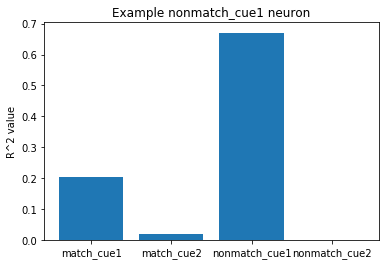

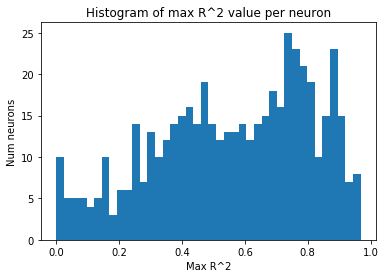

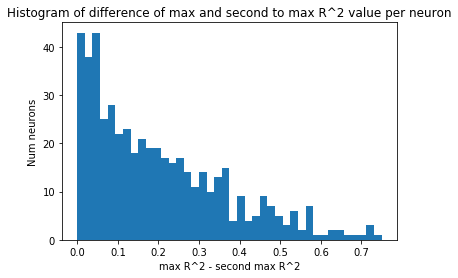

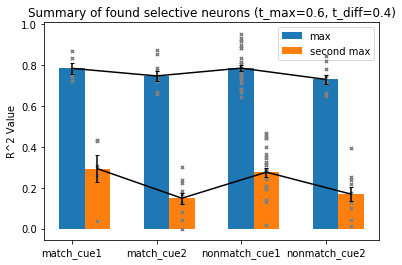

In [130]:
diffs = np.zeros(N_PFC_NEURONS)
maxs = np.zeros(N_PFC_NEURONS)

max_match_cue1 = []
max_match_cue2 = []
max_nonmatch_cue1 = []
max_nonmatch_cue2 = []

max2_match_cue1 = []
max2_match_cue2 = []
max2_nonmatch_cue1 = []
max2_nonmatch_cue2 = []

neurons_match_cue1 = []
neurons_match_cue2 = []
neurons_nonmatch_cue1 = []
neurons_nonmatch_cue2 = []
t_max = 0.6
t_diff = 0.4

for neuron_idx in range(N_PFC_NEURONS):
    r2_vals = V[neuron_idx,:]
    max_r2 = max(r2_vals)
    
    max_indicies = np.where(r2_vals == max_r2)[0]
    if len(max_indicies) == 2:
        maxs[neuron_idx] = max_r2
        diffs[neuron_idx] = 0
        continue
    
    max_idx = max_indicies[0]
    r2_vals_tmp = r2_vals.copy()
    r2_vals_tmp[max_idx] = 0
    max2_r2 = max(r2_vals_tmp)
    diffs[neuron_idx] = max_r2 - max2_r2
    maxs[neuron_idx] = max_r2
    
    if not (maxs[neuron_idx] >= t_max and diffs[neuron_idx] >= t_diff):
        continue

    if max_idx == 0:
        neurons_match_cue1.append(neuron_idx)
        max_match_cue1.append(max_r2)
        max2_match_cue1.append(max2_r2)
    elif max_idx == 1:
        neurons_match_cue2.append(neuron_idx)
        max_match_cue2.append(max_r2)
        max2_match_cue2.append(max2_r2)
    elif max_idx == 2:
        neurons_nonmatch_cue1.append(neuron_idx)
        max_nonmatch_cue1.append(max_r2)
        max2_nonmatch_cue1.append(max2_r2)
    elif max_idx == 3:
        neurons_nonmatch_cue2.append(neuron_idx)
        max_nonmatch_cue2.append(max_r2)
        max2_nonmatch_cue2.append(max2_r2)
        
example_neuron = neurons_nonmatch_cue1[3]
r2_vals = V[example_neuron,:]
plt.bar(["match_cue1", "match_cue2", "nonmatch_cue1", "nonmatch_cue2"], r2_vals)
plt.title("Example nonmatch_cue1 neuron")
plt.ylabel("R^2 value")
plt.show()

plt.hist(maxs, bins=40)
plt.xlabel("Max R^2")
plt.ylabel("Num neurons")
plt.title("Histogram of max R^2 value per neuron")
plt.show()

plt.hist(diffs, bins=40)
plt.xlabel("max R^2 - second max R^2")
plt.ylabel("Num neurons")
plt.title("Histogram of difference of max and second to max R^2 value per neuron")
plt.show()
    
D = {}
D["match_cue1"] = (max_match_cue1, max2_match_cue1)
D["match_cue2"] = (max_match_cue2, max2_match_cue2)
D["nonmatch_cue1"] = (max_nonmatch_cue1, max2_nonmatch_cue1)
D["nonmatch_cue2"] = (max_nonmatch_cue2, max2_nonmatch_cue2)

# Plot bar plot
means1 = []
means2 = []
std_errs1 = []
std_errs2 = []

d1s = []
d2s = []
for key in D:
    d1 = D[key][0]
    d2 = D[key][1]
    means1.append(np.mean(d1))
    means2.append(np.mean(d2))
    std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
    std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
    d1s.append(d1)
    d2s.append(d2)

w = 0.3
plt.bar(range(len(means1)), means1, width=w, label="max")
plt.errorbar(D.keys(), means1, std_errs1, color="k", capsize=2, zorder=20)
plt.bar(np.arange(len(means2))+w, means2, width=w, label="second max")
plt.errorbar(np.arange(len(std_errs2))+w, means2, std_errs2, color="k", capsize=2, zorder=20)
for i in range(len(d1s)):
    plt.scatter(np.ones(len(d1s[i]))*i, d1s[i], color="grey", marker="x", s=10, zorder=10)
    plt.scatter(np.ones(len(d2s[i]))*i+w, d2s[i], color="grey", marker="x", s=10, zorder=10)
plt.legend()
plt.ylabel("R^2 Value")
plt.title(f"Summary of found selective neurons (t_max={t_max}, t_diff={t_diff})")
plt.show()



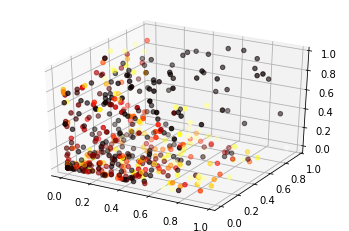

In [131]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(V[:,0], V[:,1],V[:,2], c=V[:,3])
plt.show()

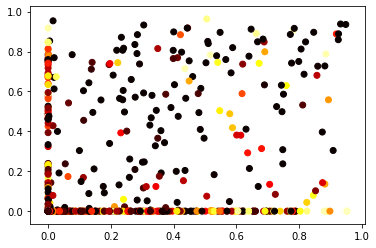